In [1]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
#import input_data
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC, DiagHessian, DiagGGNMC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
#from backpack.core.layers import Flatten
import pytest
from DirLPA_utils import * 
import os
from bpjacext import NetJac

import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

print(torch.__version__)

ModuleNotFoundError: No module named 'bpjacext'

# prepare and test plotting

In [ ]:
# just copy pasted from this link: http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import math
from functools import reduce
from math import gamma
from operator import mul
from scipy.special import loggamma

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)


"""
plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')
"""

midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def logistic_transform(x):
    
    x_D = x[:-1]
    #print("x_D: ", x_D, x[-1])
    out = np.log(x/x[-1])
    return(out)

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))    


class Dirichlet(object):
    def __init__(self, alpha):
        self._alpha = np.array(alpha)
        self._coef = 1/(beta_function(alpha) + 10e-20)
        
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    
class Normal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.const = 1 / (np.sqrt((2*np.pi)**3 * np.linalg.det(Sigma)))
        
    def pdf(self, x):
        """Calculate 3D Gaussian"""
        y = self.const * np.exp(-0.5 * (x - self.mu).T @ self.Sigma @ (x - self.mu))
        return(y)
    
class logitNormal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.const = 1/ (np.sqrt(np.linalg.det(2 * np.pi * self.Sigma)))
        
    def pdf(self, x):
        part_one = self.const / np.prod(x)
        logistic = logistic_transform(x)
        part_two = np.exp(-0.5*(logistic - self.mu).T @ self.Sigma @ (logistic - self.mu))
        y = part_one * part_two
        return(y)

def draw_pdf_contours(dist, nlevels=200, subdiv=5, MAP = [1/3]*3, title=None, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    #print([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    MAP_vals = []
    for xy in zip(trimesh.x, trimesh.y):
        xy_ = xy2bc(xy)
        if np.linalg.norm(MAP - xy_) <  1*10e-3:
            MAP_vals.append(1)
        else:
            MAP_vals.append(0)
    
    plt.tricontourf(trimesh, pvals, nlevels, alpha=1, cmap="viridis", **kwargs)
    #plt.tricontourf(trimesh, MAP_vals, nlevels, alpha=0.1, cmap="Reds", **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if title:
        plt.title(title)
    
draw_pdf_contours(Dirichlet([0.03117058, 0.1298957,  0.29554912]), title='test')
#draw_pdf_contours(Dirichlet([5,5,5]), title='test')

In [ ]:
from scipy.stats import dirichlet

def argmin_norm(sample, positions):
    return(np.argmin(np.sum(np.square(sample - positions), axis=1)))

def draw_triple_pdfs(alphas, MAPs, filename, nlevels=200, subdiv=5, sample=False, num_samples=100000, **kwargs):
    
    fig, axs = plt.subplots(nrows=1, ncols=len(dists), sharex=False, figsize=(15, 5))
    
    for i, alpha in enumerate(alphas):
        
        refiner = tri.UniformTriRefiner(triangle)
        trimesh = refiner.refine_triangulation(subdiv=subdiv)
        if sample:
            xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
            dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)
            counts = np.zeros(len(xys))
            for x in dirichlet_samples:
                counts[argmin_norm(x, xys)] += 1

            pvals = counts/num_samples
        else:
            d = Dirichlet(alpha)
            pvals = [d.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
        
        # add a red dot for the MAP
        MAP_vals = []
        for xy in zip(trimesh.x, trimesh.y):
            xy_ = xy2bc(xy)
            if np.linalg.norm(MAPs[i] - xy_) <  1*10e-3:
                MAP_vals.append(1)
            else:
                MAP_vals.append(0)
                

        axs[i].tricontourf(trimesh, pvals, nlevels, **kwargs)
        #axs[i].tricontourf(trimesh, MAP_vals, nlevels, alpha=0.1, cmap="Reds", **kwargs)
        axs[i].axis('equal')
        axs[i].set_xlim(0, 1)
        axs[i].set_ylim(0, 0.75**0.5)
        axs[i].axis('off')
    
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [ ]:
a_1 = [1,1,1]
a_2 = [2,2,2]
a_3 = [3,3,3]
dists = [a_1, a_2, a_3]
MAPs = [[0.4,0.4,0.2], [0.3,0.4,0.3], [0.7,0.2,0.1]]
draw_triple_pdfs(dists, MAPs, filename='figures/test.pdf', sample=True)

# make toy dataset

In [ ]:
''' ============================== PLOTTING TOOLS ================================='''

def plot_mc(X, Y, X1_test, X2_test, py_map, py_mcd, py, fname='toy_2d_dnn'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
    pys = (py_map, py_mcd, py)
    ims = []
    cmap = 'Blues'
    
    for ax, p in zip(axes.flat, pys):
        print(p.shape)
#         cnt = ax.contour(X1_test, X2_test, py.reshape(120, 120), levels=(0.25,), colors='black', linewidths=3)
#         ax.clabel(cnt, inline=True, fontsize=16, fmt='%.1f')
        norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
        im = ax.contourf(X1_test, X2_test, p.reshape(120, 120), alpha=0.4, levels=np.arange(0, 1.01, 0.1), cmap=cmap, vmin=0, vmax=1)
        ax.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='cyan', edgecolors='k')
        ax.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k')
        ax.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='magenta', edgecolors='k')
        #ax.scatter(X[Y==3][:, 0], X[Y==2][:, 1], c='orange', edgecolors='k')
        ax.set_xticks([])
        ax.set_yticks([])
        ims.append(im)
        
#     fig.colorbar(ims[0], ax=axes.ravel().tolist(), ticks=np.arange(0, 1.01, 0.1))
    plt.savefig(f'figs/{fname}.pdf')
    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.show();
    
    
def plot_separate(X, Y, X1_test, X2_test, py_map, py_mcd, py, fname):
#     fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
    pys = (py_map, py_mcd, py)
    names = ('map', 'mcd', 'laplace')
    ims = []
    cmap = 'Blues'
    
    for name, py in zip(names, pys):
        levels = np.arange(0, 1.1, 0.1)
        lws = [0.5]*5 + [3] + [0.5]*5
        
        cnt = plt.contour(X1_test, X2_test, py.reshape(120, 120), levels=levels, colors='black', linewidths=lws)
        plt.clabel(cnt, inline=True, fontsize=16, fmt='%.1f')
        norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
        im = plt.contourf(X1_test, X2_test, py.reshape(120, 120), alpha=0.5, levels=np.arange(0, 1.01, 0.1), cmap=cmap, vmin=0, vmax=1)
        plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='cyan', edgecolors='k')
        plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k')
        plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='magenta', edgecolors='k')
        #plt.scatter(X[Y==3][:, 0], X[Y==2][:, 1], c='orange', edgecolors='k')

        plt.xlim(test_range);
        plt.ylim(test_range);
        plt.xticks([]);
        plt.yticks([]);
        
        plt.savefig(f'figs/{fname}_{name}.pdf', bbox_inches='tight')
#         tikzplotlib.save(f'figs/{fname}_{name}.tex')
        plt.show();
    
    
def plot_ent_mc(X, Y, X1_test, X2_test, ent_map, ent, fname, levels=None, fmt='%d'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    cmap = 'Blues'
    ents = [ent_map, ent]
    ims = []
    
    for ax, entropy in zip(axes.flat, ents):
        cnt = ax.contour(X1_test, X2_test, Z, levels=levels, colors='black', linewidths=0.5)
        ax.clabel(cnt, inline=True, fontsize=16, fmt=fmt)
#         norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
        im = ax.contourf(X1_test, X2_test, entropy, alpha=0.5, cmap=cmap, levels=levels)
        ax.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='cyan', edgecolors='k')
        ax.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k')
        ax.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='magenta', edgecolors='k')
        #ax.scatter(X[Y==3][:, 0], X[Y==2][:, 1], c='orange', edgecolors='k')
    #     ax.set_xticks([])
    #     ax.set_yticks([])
        ims.append(im)

    fig.colorbar(ims[0], ax=axes.ravel().tolist())
    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);
    plt.savefig(f'figs/{fname}.pdf', bbox_inches='tight')
#     tikzplotlib.save(f'figs/{fname}.tex')
    plt.show();
    
    
    
def plot_aux_mc(X, Y, X1_test, X2_test, Z, fname, levels=None, fmt='%.1f'):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    cmap = 'Blues'

    cnt = plt.contour(X1_test, X2_test, Z, levels=levels, colors='black', linewidths=0.5)
    plt.clabel(cnt, inline=True, fontsize=16, fmt=fmt)
#     norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
    im = plt.contourf(X1_test, X2_test, Z, alpha=0.5, cmap=cmap, levels=levels)
    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='cyan', edgecolors='k')
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k')
    plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='magenta', edgecolors='k')
    #plt.scatter(X[Y==3][:, 0], X[Y==3][:, 1], c='orange', edgecolors='k')
#     ax.set_xticks([])
#     ax.set_yticks([])

#     fig.colorbar(im)
    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);
    plt.savefig(f'figures/{fname}.pdf', bbox_inches='tight')
#     tikzplotlib.save(f'figs/{fname}.tex')
    plt.show();
    
def plot_aux_mc_with_OOD(X, Y, X1_test, X2_test, X_test_in, Y_test_in, X_out, Y_out, Z, fname, levels=None, fmt='%.1f'):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    cmap = 'Blues'

    cnt = plt.contour(X1_test, X2_test, Z, levels=levels, colors='black', linewidths=0.5)
    plt.clabel(cnt, inline=True, fontsize=16, fmt=fmt)
    
    im = plt.contourf(X1_test, X2_test, Z, alpha=0.5, cmap=cmap, levels=levels)

    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='#6efaf4', edgecolors='k') #cyan
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='#f4fa6e', edgecolors='k') #yellow
    plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='#ef6efa', edgecolors='k') #magenta
    plt.scatter(X_test_in[Y_test_in==0][:, 0], X_test_in[Y_test_in==0][:, 1], c='black', edgecolors='k')
    plt.scatter(X_test_in[Y_test_in==1][:, 0], X_test_in[Y_test_in==1][:, 1], c='black', edgecolors='k')
    plt.scatter(X_test_in[Y_test_in==2][:, 0], X_test_in[Y_test_in==2][:, 1], c='black', edgecolors='k')
    plt.scatter(X_out[Y_out==0][:, 0], X_out[Y_out==0][:, 1], c='#2b33dd', edgecolors='k')
    plt.scatter(X_out[Y_out==1][:, 0], X_out[Y_out==1][:, 1], c='#1ed30c', edgecolors='k')
    plt.scatter(X_out[Y_out==2][:, 0], X_out[Y_out==2][:, 1], c='#d5193e', edgecolors='k')

    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);
    plt.savefig(f'figures/{fname}.pdf', bbox_inches='tight')
#     tikzplotlib.save(f'figs/{fname}.tex')
    plt.show();

In [ ]:
from sklearn import datasets
np.random.seed(42)
size = 250
test_size = 3
train_range = (-10, 10)
test_range1 = (-20, -30)
test_range2 = (10, 25)
#test_range2 = (-200, -100)

X, Y = datasets.make_blobs(n_samples=size, centers=3, cluster_std=2, 
                           center_box=train_range, random_state=41)

X_test_in, Y_test_in = datasets.make_blobs(n_samples=test_size, centers=3, cluster_std=2, 
                           center_box=train_range, random_state=41)

X_out, Y_out = datasets.make_blobs(n_samples=test_size, centers=3, cluster_std=2, 
                           center_box=test_range2, random_state=50)

train_range = (-5, 5)
test_range = (-25, 35)
test_range1 = (-20, 5)
test_range2 = (10, 25)
#test_range2 = (-205, -95)
test_ranges = [test_range, test_range, test_range, test_range]

plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='#6efaf4', edgecolors='k') #cyan
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='#f4fa6e', edgecolors='k') #yellow
plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='#ef6efa', edgecolors='k') #magenta
plt.scatter(X_test_in[Y_test_in==0][:, 0], X_test_in[Y_test_in==0][:, 1], c='black', edgecolors='k')
plt.scatter(X_test_in[Y_test_in==1][:, 0], X_test_in[Y_test_in==1][:, 1], c='black', edgecolors='k')
plt.scatter(X_test_in[Y_test_in==2][:, 0], X_test_in[Y_test_in==2][:, 1], c='black', edgecolors='k')
plt.scatter(X_out[Y_out==0][:, 0], X_out[Y_out==0][:, 1], c='#2b33dd', edgecolors='k')
plt.scatter(X_out[Y_out==1][:, 0], X_out[Y_out==1][:, 1], c='#1ed30c', edgecolors='k')
plt.scatter(X_out[Y_out==2][:, 0], X_out[Y_out==2][:, 1], c='#d5193e', edgecolors='k')

plt.xlim(test_range);
plt.ylim(test_range);

plt.show()

In [ ]:
torch.manual_seed(42)

m, n = X.shape
k = 3
feat_size = 100

var_prior = 100
Prec_prior = 1/var_prior * torch.eye(k*feat_size)

X_t = torch.from_numpy(X).float()
Y_t = torch.from_numpy(Y).long()


feature_extr = nn.Sequential(
    nn.Linear(n, feat_size),
    nn.Tanh(), 
    nn.Linear(100, 100), 
    nn.Tanh(), 
    nn.Linear(100, feat_size), 
    nn.Sigmoid()
)

model_lin = nn.Linear(feat_size, k, bias=False)
model = nn.Sequential(
    feature_extr,
    model_lin
)
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-2)


def log_posterior(y, w=None):
    w = w if w is not None else list(model.parameters())[-1]
    w = w.flatten()
    loglik = -F.cross_entropy(y, Y_t, reduction='sum') 
    logprior = -1/2 * w @ Prec_prior @ w
    return loglik + logprior
    
    
# Find MAP estimate of the posterior
print(f'Log posterior before training: {log_posterior(model(X_t).squeeze()):.3f}')

for it in range(5000):
    y = model(X_t).squeeze()
    l = F.cross_entropy(y, Y_t, reduction='mean')
    l.backward()
    opt.step()
    opt.zero_grad()

print(f'Log posterior at MAP: {log_posterior(model(X_t).squeeze()):.3f}')

In [ ]:
''' ============================== MAP ================================='''

model.eval()

# Test data
test_rng = np.linspace(*test_range, 120)
X1_test, X2_test = np.meshgrid(test_rng, test_rng)
X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T

X_test_t = torch.from_numpy(X_test).float()

with torch.no_grad():
    model.eval()
    py_map = F.softmax(model(X_test_t), 1).squeeze().numpy()

entropy_map = -np.sum(py_map*np.log(py_map+1e-8), axis=1)
py_map = py_map.max(1)

In [ ]:
## play around with Backpack
lossfunc = torch.nn.CrossEntropyLoss()

extend(lossfunc, debug=False)
extend(model, debug=False)

device = 'cpu'

Hessian_diag = []
for param in model.parameters():
    ps = param.size()
    print("parameter size: ", ps)
    Hessian_diag.append(torch.zeros(ps, device=device))
    #print(param.numel())
    
batch_size = None

tau = 1/10
    
with backpack(DiagHessian()):
    

    model.zero_grad()
    lossfunc(model(X_t), Y_t).backward()

    with torch.no_grad():
        # Hessian of weight
        for idx, param in enumerate(model.parameters()):

            H_ = param.diag_h
            rho = 0.95

            Hessian_diag[idx] = rho*Hessian_diag[idx] + (1-rho)*H_

        
    #combine all elements of the Hessian to one big vector
    Hessian_diag = torch.cat([el.view(-1) for el in Hessian_diag])
    print("Hessian_size: ", Hessian_diag.size())
    num_params = np.sum([p.numel() for p in model.parameters()])
    assert(num_params == Hessian_diag.size(-1))
        

# compute MAP

In [ ]:
def predict_MAP(model, x):
    
    x = torch.from_numpy(x).float()
    out = model(x).detach()
    out = torch.softmax(out, 1)
    return(out)

In [ ]:
targets = Y_test_in
targets_out = Y_out

Y_in_MAP = predict_MAP(model, X_test_in).numpy()
Y_out_MAP = predict_MAP(model, X_out).numpy()

acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(Y_in_MAP, targets)
acc_out_MAP, prob_correct_out_MAP, ent_out_MAP, MMC_out_MAP, auroc_out_MAP = get_out_dist_values(Y_in_MAP, Y_out_MAP, targets_out)

print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'Y_test', 'MAP')
print_out_dist_values(acc_out_MAP, prob_correct_out_MAP, ent_out_MAP, MMC_out_MAP, auroc_out_MAP, 'out', 'MAP')

In [ ]:
def compute_jacobians_with_backpack(model, x, y, lossfunc):
    """
    Returns the jacobians of the network

    The output is a list. Each element in the list is a tensor
    corresponding to the model.parameters().

    The tensor are of the form [N, *, C] where N is the batch dimension,
    C is the number of classes (output size of the network)
    and * is the shape of the model parameters
    """
    loss = lossfunc(model(x), y)

    with backpack(NetJac()):
        loss.backward()

    jacs = []
    for p in model.parameters():
        jacs.append(p.netjacs.data)
    return jacs

def transform2full_jac(backpack_jacobian):

    jac_full = []
    #batch_size
    N = backpack_jacobian[0].size(0)
    #num classes
    k = backpack_jacobian[0].size(-1)
    for j in backpack_jacobian:
        jac_full.append(j.view(N, -1, k).permute(0,2,1))
    jac_full = torch.cat(jac_full, dim=-1)
    return(jac_full)

def get_Jacobian(model, x, y, lossfunc):
    return(transform2full_jac(compute_jacobians_with_backpack(model, x, y, lossfunc)))

In [ ]:
def get_alpha_from_Normal(mu, Sigma):
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*torch.Tensor(mu)), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    assert(alpha.size() == mu.size())
    
    return(alpha)

def predict_DIR_LPA(model, x, y, Hessian, verbose=False):

    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    
    extend(model, debug=False)
    lossfunc = torch.nn.CrossEntropyLoss()
    extend(lossfunc, debug=False)
        
    J = get_Jacobian(model, x, y, lossfunc)
    print("Jacobian size: ", J.size())
    batch_size = J.size(0)
    num_classes = J.size(1)
    #Cov_pred = torch.zeros(batch_size, num_classes, num_classes)
    #for i in range(batch_size):
    #    Cov_pred[i] = torch.mul(J[i], Hessian) @ J[i].T    #inverting the Hessian give worse results for some reason
    Cov_pred = torch.bmm(J * Hessian, J.permute(0, 2, 1))
    #print("cov pred size: ", Cov_pred.size())

    mu_pred = model(x)

    alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()

    return(alpha)

def predict_DIR_LPA_batch(model, x, y, Hessian, verbose=True, batch_size=144):
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    
    extend(model, debug=False)
    lossfunc = torch.nn.CrossEntropyLoss()
    extend(lossfunc, debug=False)

    x_chunked = chunks(x, batch_size)
    y_chunked = chunks(y, batch_size)
    py = []
    for x_batch, y_batch in zip(x_chunked, y_chunked):
        J = get_Jacobian(model, x_batch, y_batch, lossfunc)
        print("Jacobian size: ", J.size())
        batch_size = J.size(0)
        num_classes = J.size(1)
        #Cov_pred = torch.zeros(batch_size, num_classes, num_classes)
        #for i in range(batch_size):
        #    Cov_pred[i] = torch.mul(J[i], Hessian) @ J[i].T    #inverting the Hessian give worse results for some reason
        Cov_pred = torch.bmm(J * Hessian, J.permute(0, 2, 1))
        #print("cov pred size: ", Cov_pred.size())

        mu_pred = model(x_batch)
        #print(Cov_pred)
        post_pred = MultivariateNormal(mu_pred, Cov_pred)

        alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()
        py.append(alpha)

    return torch.cat(py)

In [ ]:
Y_proxy = torch.zeros(X_test_t.size(0)).numpy()
py_DIR_LPA = predict_DIR_LPA_batch(model, X_test_t.numpy(), Y_proxy, Hessian_diag).numpy()
py_DIR_LPA /= py_DIR_LPA.sum(1).reshape(-1,1)

entropy_DIR_LPA = -np.sum(py_DIR_LPA*np.log(py_DIR_LPA + 1e-8), axis=1)
py_DIR_LPA = py_DIR_LPA.max(1)


print(py_DIR_LPA.max(), py_DIR_LPA.min())
print(entropy_DIR_LPA.max(), entropy_DIR_LPA.min())

plot_aux_mc_with_OOD(X, Y, X1_test, X2_test, X_test_in, Y_test_in, X_out, Y_out, entropy_DIR_LPA.reshape(120, 120), 'ent_toy_2d_nn_multiclass_DIR_LPA')

In [ ]:
Y_in_DIR_LPA = predict_DIR_LPA(model, X_test_in, Y_test_in, Hessian_diag).numpy()
Y_out_DIR_LPA = predict_DIR_LPA(model, X_out, Y_out, Hessian_diag).numpy()

# plot the Dirichlets

In [31]:
MAP0 = Y_in_MAP[0]
MAP1 = Y_in_MAP[1]
MAP2 = Y_in_MAP[2]

d0 = Y_in_DIR_LPA[0]
d1 = Y_in_DIR_LPA[1]
d2 = Y_in_DIR_LPA[2]

t0 = targets[0]
t1 = targets[1]
t2 = targets[2]
print(MAP0, MAP1, MAP2)
print(d0, d1, d2)
print(t0, t1, t2)

[9.9047236e-03 9.8947877e-01 6.1657978e-04] [1.3540914e-02 7.4117183e-04 9.8571789e-01] [0.9754591  0.01593575 0.00860509]
[  159.01851 14929.996     156.88861] [  240.17477    92.18621 25462.76   ] [1176.3173     28.215065   63.492733]
1 2 0


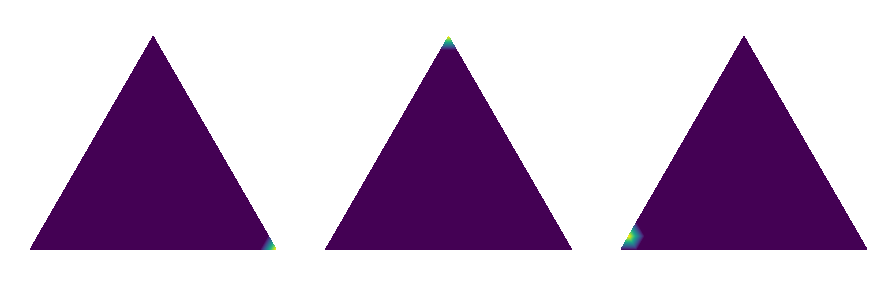

In [32]:
dists = [d0, d1, d2]
MAPs = [MAP0, MAP1, MAP2]
filename_in = 'figures/toy_data_3D_simplex_in.pdf'
draw_triple_pdfs(dists, MAPs, filename=filename_in ,subdiv=4, sample=True)

In [33]:
MAP0_out = Y_out_MAP[0]
MAP1_out = Y_out_MAP[1]
MAP2_out = Y_out_MAP[2]


d0_out = Y_out_DIR_LPA[0]
d1_out = Y_out_DIR_LPA[1]
d2_out = Y_out_DIR_LPA[2]

t0_out = targets_out[0]
t1_out = targets_out[1]
t2_out = targets_out[2]

print(MAP0_out, MAP1_out, MAP2_out)
print(d0_out, d1_out, d2_out)
print(t0_out, t1_out, t2_out)

[0.00082455 0.53181666 0.46735877] [0.00145482 0.94078285 0.05776229] [0.00081545 0.5067322  0.49245235]
[   56.684174 11381.226    15961.682   ] [  27.84823 8361.834    229.84174] [   56.321083  9995.988    16159.191   ]
1 0 2


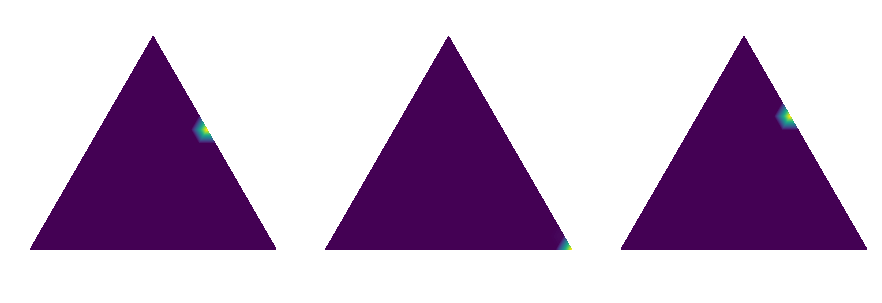

In [34]:
dists = [d0_out, d1_out, d2_out]
MAPs = [MAP0_out, MAP1_out, MAP2_out]
filename_out = 'figures/toy_data_3D_simplex_out.pdf'
draw_triple_pdfs(dists, MAPs, filename=filename_out, subdiv=4, sample=True)